## Taxi Trip Duration
1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your system


## Frame the problem and look at the big picture

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. 
In this project the goal is to make a model based on individual trip attributes, to be able to predict the duration of each trip in the test set.


## Get the data

In [22]:
# get data for dataset

# Common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import os
import tarfile
from six.moves import urllib

TAXI_PATH = os.path.join("data", "taxi")

def load_taxi_data(taxi_path=TAXI_PATH):
    csv_path = os.path.join(taxi_path, "train.csv")
    return pd.read_csv(csv_path)

import warnings
warnings.filterwarnings(action="ignore", message="^RuntimeWarning")

In [23]:
train = load_taxi_data()
csv_path = os.path.join(TAXI_PATH, "test.csv")
test = pd.read_csv(csv_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Explore the data to gain insights - visualising the data

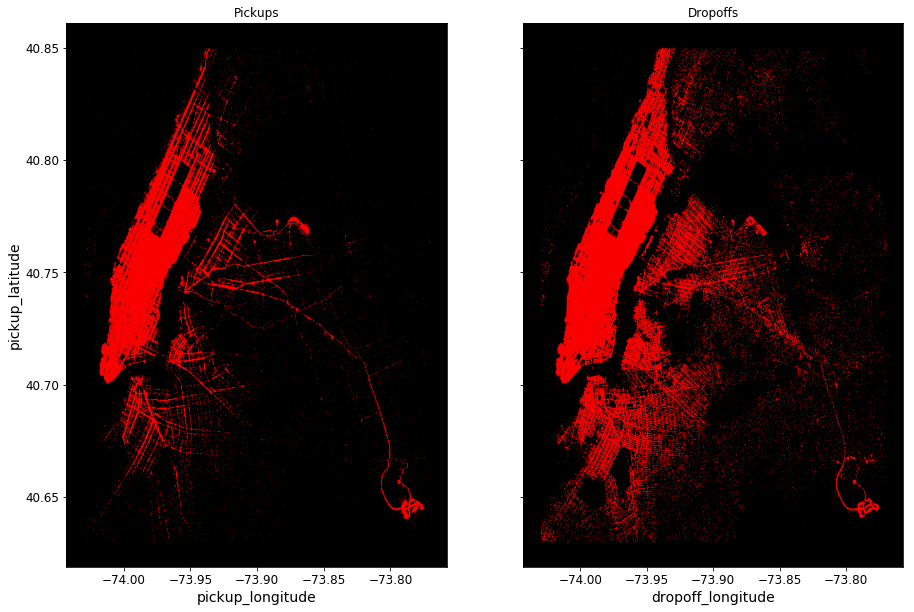

In [24]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.pickup_latitude > south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude > south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude > west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude > west) & (train.dropoff_longitude < east)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 



As we can se in the above map - most of the journeys have been from and to manhattan.
There are two airports, John F. Kennedy and LA Guardia Airport in queens which has a good amount of taxi trips from and too. 
When calculating the euclidean distance the distance will be hugely afftected by the taxi trips that start in manhattan and ends outside.


## Viewing the pickups and dropoffs of trips in folium

In [25]:
import folium 

newyork_map = folium.Map(location=[40.767937,-73.982155 ], tiles='OpenStreetMap', zoom_start=12)

def createMap(geo_map, data, i=200):
    for each in train[:i].iterrows():
        p1 = [each[1]['pickup_latitude'] ,each[1]['pickup_longitude']]
        p2 = [each[1]['dropoff_latitude'], each[1]['dropoff_longitude']]
        folium.CircleMarker(p1,
                            radius=3,
                            color='blue',
                            popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.CircleMarker(p2,
                            radius=3,
                            color='red',
                            popup=str(each[1]['dropoff_latitude'])+','+str(each[1]['dropoff_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.PolyLine(locations=[p1, p2], color='green').add_to(geo_map)
    
createMap(newyork_map, train)

newyork_map

In [26]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,945.99
std,0.50,1.31,0.04,0.03,0.03,0.03,5252.16
min,1.00,0.00,-74.03,40.63,-74.03,40.63,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,656.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1059.00
max,2.00,6.00,-73.77,40.85,-73.77,40.85,3526282.00


1. Looking at count of all columns, we can conclude we have have no missing values.
2. There is an outlier where the passenger count is 0. We need to remove that.
3. There is also a minimum trip duration of 1 second, those trips are going nowhere and the maximum is 35,26,282 seconds.
The outliers needs to be removed. 

In [27]:
test.isnull().sum(axis=0).sum(axis=0)

0

In [28]:
train.isnull().sum(axis=0).sum(axis=0)

0

There are no missing values.

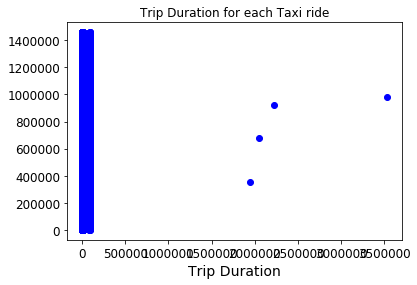

In [30]:
plt.scatter(train.trip_duration,train.index,color="blue")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

Looks like some trips are going too far away from New York city(Long rides who knows). These are outliers. Since the evaluation metrics is RMSLE(Root Mean Squared Logarithmic Error), we can log transform trip duration and use RMSE(Root Mean Squared Error) for training. So that outliers won't affect model performance much. Don't forget to take exponential of it while submitting submission file.

In [31]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


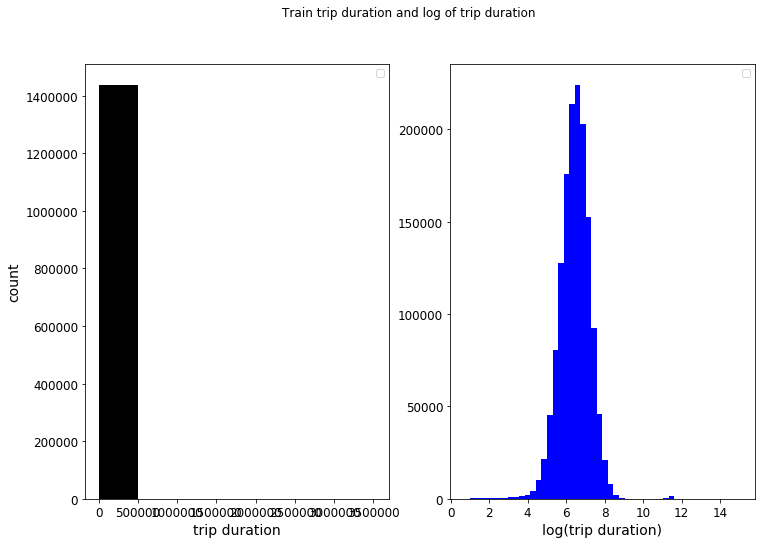

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train.trip_duration,color='black',bins=7)
ax2.hist(train.log_trip_duration,bins=50,color='blue');

In [34]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


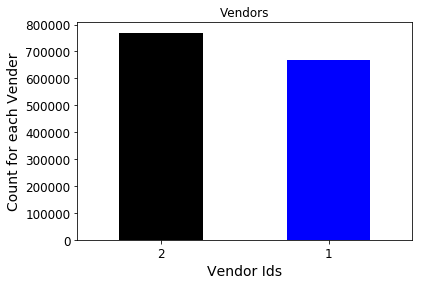

In [35]:
train["vendor_id"].value_counts().plot(kind='bar',color=["black","blue"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vender")
plt.xlabel("Vendor Ids");

Only 2 Vendors are there, they can be representing 2 taxi companies. Vendor 2 has more share in taxi rides in New York city.(Better drivers ;))

How many passengers are traveling together?

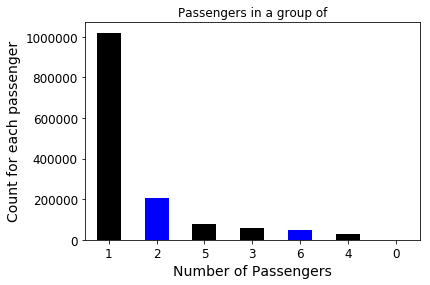

In [36]:
train["passenger_count"].value_counts().plot(kind='bar',color=["black","blue"])
plt.title("Passengers in a group of")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for each passenger")
plt.xlabel("Number of Passengers");



Most popular choice of travel is single.
2nd popular way of ride is with a single friend.
May be for long cars popular choice of travel is in group of 5 and then in group of 6 people.
There are only 3 trips in group of 7 and single trip in group of 8 and 9 each.
There are 60 trips with zero passengers. Those must be outliers and have to be removed. Because no taxi ride can happen without passenger, at least paid one.


## Whether the Trip Details are Stored Or Forwarded?

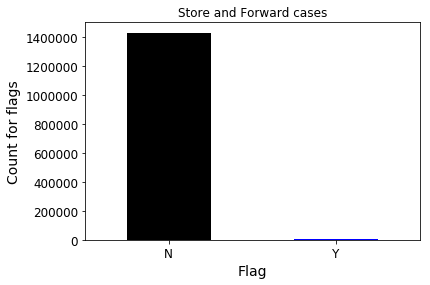

In [37]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar',color=["black","blue"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag");

Almost all the journey details were immediately sent to vendors. Very few stored in device memory may be due to bad signal or bad weather.


## Feature Engineering

How about Dates and timings of the trips? - our temporal friends

We can extract lot of insights from dates and time data we have.

1. Pickup hour rushes can define start of office timings and drop offs in evening can tell till what time New Yorkers work.
2. Weekdays and weekends can show another angle of city life. Weekends people will be getting up late and starting day late compared to weekdays. Also parties can go beyond midnight hours on weekends.
3. We can also look out for some kind of seasonality. For example, during winter seasons traffic will be going slow due to snowfalls or wetness on Roads. So, trip Duration will be longer in winters than other seasons.


In [51]:

#time train

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

train['pickup_weekday']              = pd.to_datetime(train.pickup_datetime).dt.dayofweek.astype('uint8')
train['pickup_day']                  = pd.to_datetime(train.pickup_datetime).dt.day.astype('uint8')
train['pickup_hour']                 = pd.to_datetime(train.pickup_datetime).dt.hour.astype('uint8')
train['pickup_minute']               = pd.to_datetime(train.pickup_datetime).dt.minute.astype('uint8')
train['pickup_second']               = pd.to_datetime(train.pickup_datetime).dt.second.astype('uint8')
train["pickup_dayofyear"]            = pd.to_datetime(train.pickup_datetime).dt.dayofyear.astype('uint8')
train['pickup_month']                = pd.to_datetime(train.pickup_datetime).dt.month.astype('uint8')

train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

In [52]:
# time test 

test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

test['pickup_weekday']              = pd.to_datetime(test.pickup_datetime).dt.dayofweek.astype('uint8')
test['pickup_day']                  = pd.to_datetime(test.pickup_datetime).dt.day.astype('uint8')
test['pickup_hour']                 = pd.to_datetime(test.pickup_datetime).dt.hour.astype('uint8')
test['pickup_minute']               = pd.to_datetime(test.pickup_datetime).dt.minute.astype('uint8')
test['pickup_second']               = pd.to_datetime(test.pickup_datetime).dt.second.astype('uint8')
test["pickup_dayofyear"]            = pd.to_datetime(test.pickup_datetime).dt.dayofyear.astype('uint8')
test['pickup_month']                = pd.to_datetime(test.pickup_datetime).dt.month.astype('uint8')

test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

## SHOW TIME GRAPHS

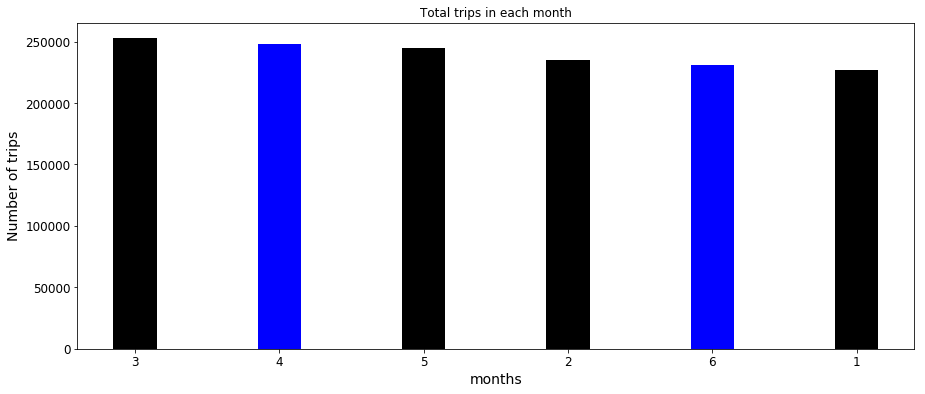

In [54]:
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["black","blue"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");


Convert storea and forward flag.

In [45]:

train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')


In [44]:
## Distances

In [43]:
import mpu

def calculateDistances(data, distances):
    for each in data.iterrows():
        lat1 = float(each[1]['pickup_latitude'])
        lon1 = float(each[1]['pickup_longitude'])
        lat2 = float(each[1]['dropoff_latitude'])
        lon2 = float(each[1]['dropoff_longitude'])
        dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
        distances.append(dist)
        

distances = []
calculateDistances(train, distances)

distances = np.array(distances)
train['euclidean_distance'] = distances
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_weekday,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_dayofyear,pickup_dt,pickup_week_hour,euclidean_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,...,6.12,0,14,17,24,55,74,6369878.00,17,1.50
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,...,6.50,6,12,0,43,35,164,14085798.00,144,1.81
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,...,7.66,1,19,11,35,24,19,1596907.00,35,6.39
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,...,6.06,2,6,19,32,31,97,8364734.00,67,1.49
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,...,6.08,5,26,13,30,55,86,7392638.00,133,1.19


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438626 entries, 0 to 1458643
Data columns (total 21 columns):
id                    1438626 non-null object
vendor_id             1438626 non-null int64
pickup_datetime       1438626 non-null datetime64[ns]
dropoff_datetime      1438626 non-null datetime64[ns]
passenger_count       1438626 non-null int64
pickup_longitude      1438626 non-null float64
pickup_latitude       1438626 non-null float64
dropoff_longitude     1438626 non-null float64
dropoff_latitude      1438626 non-null float64
store_and_fwd_flag    1438626 non-null int64
trip_duration         1438626 non-null int64
log_trip_duration     1438626 non-null float64
pickup_weekday        1438626 non-null uint8
pickup_day            1438626 non-null uint8
pickup_hour           1438626 non-null uint8
pickup_minute         1438626 non-null uint8
pickup_second         1438626 non-null uint8
pickup_dayofyear      1438626 non-null uint8
pickup_dt             1438626 non-null float64
p

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 17 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null int64
pickup_weekday        625134 non-null uint8
pickup_day            625134 non-null uint8
pickup_hour           625134 non-null uint8
pickup_minute         625134 non-null uint8
pickup_second         625134 non-null uint8
pickup_dayofyear      625134 non-null uint8
pickup_dt             625134 non-null float64
pickup_week_hour      625134 non-null uint8
dtypes: datetime64[ns](1), float64(5), int64(3), object(1), uint8(7)
memory usage: 51.9+ MB


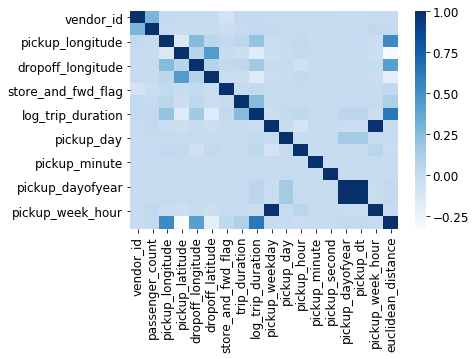

In [48]:
import seaborn as sns
sns.heatmap(train.corr(), cmap='Blues')


In [19]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_copy.values, y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
lin_reg.score(X_train_copy, y_train.values)

0.023148531847391074

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
#rf_clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
#y_train.values
#X_train_copy.values
#rf_clf.fit(X_train_copy, y_train)

In [22]:
#rf_clf.fit(X_train_copy.values.ravel(), y_train.values.ravel())

In [23]:
#rf_clf.score(X_val, y_val)

In [24]:
#importances = rf_clf.feature_importances_

In [25]:
#indices = np.argsort(importances)[::-1]

In [26]:
#for f in range(10): 
#    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')